## Problem Statement

Financial inclusion remains one of the main obstacles to economic and human development in Africa. For example, across Kenya, Rwanda, Tanzania, and Uganda only 9.1 million adults (or 14% of adults) have access to or use a commercial bank account.

The objective of this competition is to create a machine learning model to predict which individuals are most likely to have or use a bank account. The models and solutions developed can provide an indication of the state of financial inclusion in Kenya, Rwanda, Tanzania and Uganda, while providing insights into some of the key factors driving individuals’ financial security.

## About the data
You are asked to predict the likelihood of the person having a bank account or not (Yes = 1, No = 0), for each unique id in the test dataset . You will train your model on 70% of the data and test your model on the final 30% of the data, across four East African countries - Kenya, Rwanda, Tanzania, and Uganda.
bv 
The main dataset contains demographic information and what financial services are used by approximately 33,600 individuals across East Africa. This data was extracted from various Finscope surveys ranging from 2016 to 2018, and more information about these surveys can be found here:

### Files:

1. **train.csv**: Train contains the target. This is the dataset that you will use to train your model.

2. **test.csv**: Test resembles Train.csv but without the target-related columns. This is the dataset on which you will apply your model to.

3. **VariableDefinitions.csv**: Full list of variables and their explanations:
0   country:	Country interviewee is in.
1	year:	Year survey was done in.
2	uniqueid:	Unique identifier for each interviewee
3	location_type:	Type of location
4	cellphone_access:	If interviewee has access to a cellphone
5	household_size:	Number of people living in one house
6	age_of_respondent:	The age of the interviewee
7	gender_of_respondent:	Gender of interviewee
8	relationship_with_head:	The interviewee’s relationship with the head of organisation.
9	marital_status:	The martial status of the interviewee
10	education_level:	Highest level of education
11	job_type:	Type of job interviewee has.

4. **SampleSubmission.csv**: This shows the submission format for this competition, with the ‘ID’ column mirroring that of Test.csv and the ‘target’ column containing your predictions. The order of the rows does not matter, but the names of the ID must be correct. Note that the variable ID in the submission file is: uniqueid + " x " + country name.

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.metrics import mean_absolute_error, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
# Load data
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
variable_definitions = pd.read_csv('VariableDefinitions.csv')
sample_submission = pd.read_csv('SampleSubmission (1).csv')

## Data Exploration

In [3]:
# Print first 5 rows
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [4]:
# Print train info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


There are 23524 records and 13 features in the train dataset. Interesting to note is there is no NaNs. Also, the features seem to have the right dtypes.

In [5]:
# Print number of unique values for each features
train.nunique()

country                      4
year                         3
uniqueid                  8735
bank_account                 2
location_type                2
cellphone_access             2
household_size              20
age_of_respondent           85
gender_of_respondent         2
relationship_with_head       6
marital_status               5
education_level              6
job_type                    10
dtype: int64

In [6]:
# Print unique values for year
train.year.unique()

array([2018, 2016, 2017], dtype=int64)

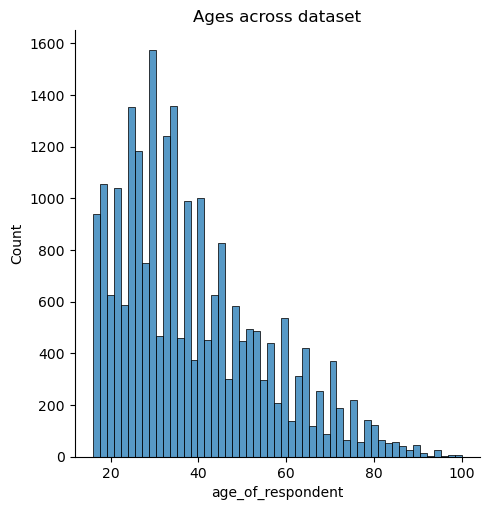

In [7]:
# Plot histogram of age
sns.displot(train.age_of_respondent);
plt.title('Ages across dataset');
plt.savefig('fig1.png')

This histogram is right-skewed with one prominent peak. Minimum age in this train dataset is around 17 years, maximum age is 100. Median age around 30 years.

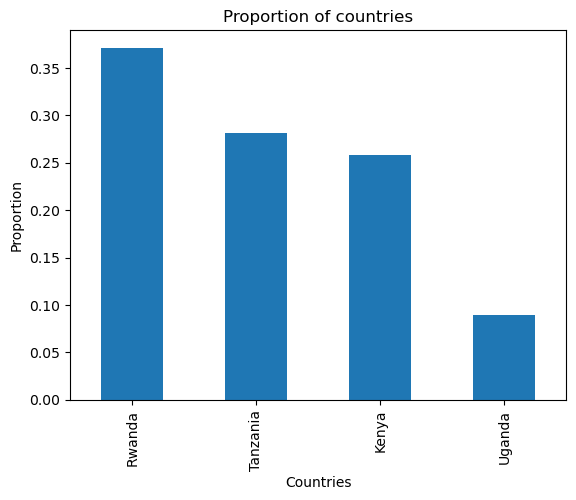

In [8]:
train.country.value_counts(normalize=True).plot(kind = 'bar');
plt.xlabel('Countries')
plt.ylabel('Proportion')
plt.title('Proportion of countries');
plt.savefig('fig2.png')

This survey happened in four countries: Rwanda, Tanzania, Kenya, and Uganda. 35% records are from Rwanda, Tanzania has about 28% records closely followed by Kenya with 25%. Uganda has around 7% of the records, the least of them all.

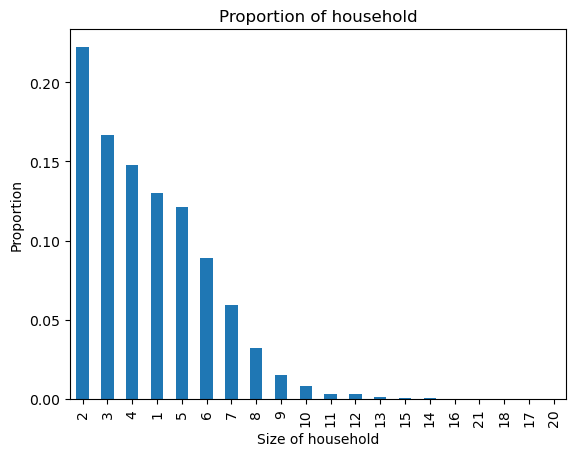

In [9]:
train.household_size.value_counts(normalize=True).plot(kind = 'bar');
plt.xlabel('Size of household')
plt.ylabel('Proportion')
plt.title('Proportion of household');
plt.savefig('fig3.png')

Highest household size is 2, least is 20

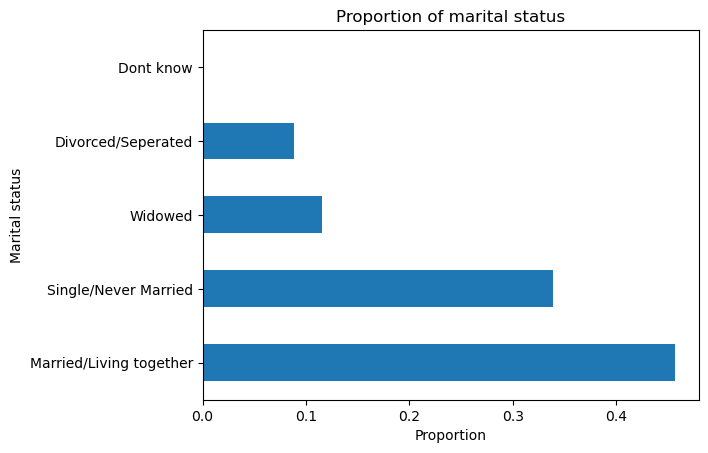

In [10]:
train.marital_status.value_counts(normalize=True).plot(kind = 'barh');
plt.xlabel('Proportion')
plt.ylabel('Marital status')
plt.title('Proportion of marital status');
plt.savefig('fig4.png')

About 80% of individuals in the train data are either married or single

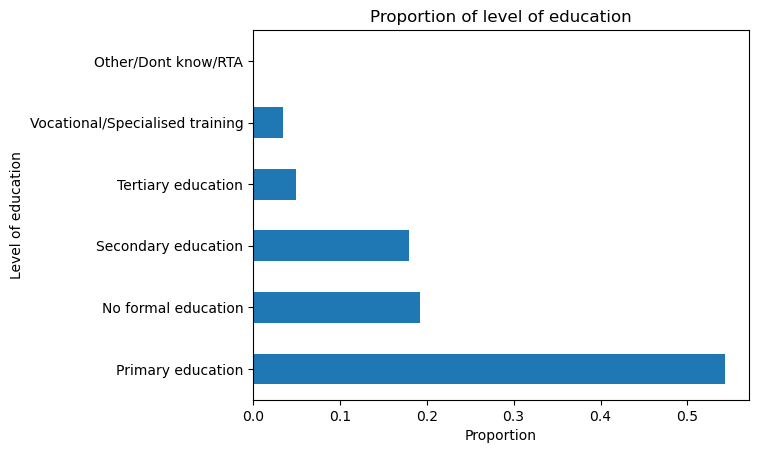

In [11]:
train.education_level.value_counts(normalize=True).plot(kind = 'barh');
plt.xlabel('Proportion')
plt.ylabel('Level of education')
plt.title('Proportion of level of education');
plt.savefig('fig5.png')

Over 50% of individuals in the train data have taken primary education, less than 20% have taken secondary education, and 5% have taken tertiary education. 

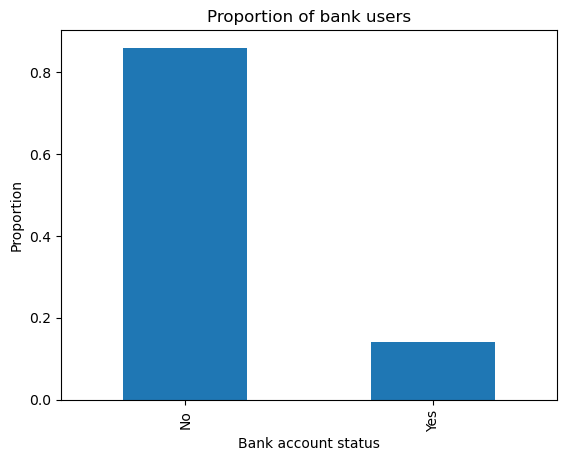

In [12]:
train.bank_account.value_counts(normalize=True).plot(kind = 'bar');
plt.xlabel('Bank account status')
plt.ylabel('Proportion')
plt.title('Proportion of bank users');
plt.savefig('fig6.png')

Over 80% have no bank account, while just over 10% do. This is the target column

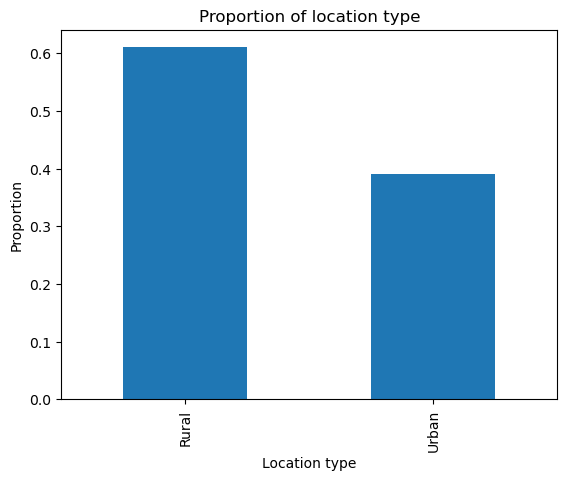

In [13]:
train.location_type.value_counts(normalize=True).plot(kind = 'bar');
plt.xlabel('Location type')
plt.ylabel('Proportion')
plt.title('Proportion of location type');
plt.savefig('fig7.png')

60% of the people in this dataset live in the rural area. 40% live in the urban area

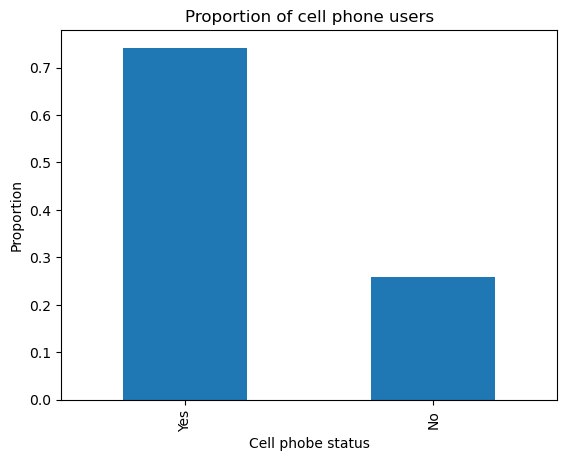

In [14]:
train.cellphone_access.value_counts(normalize=True).plot(kind = 'bar');
plt.xlabel('Cell phobe status')
plt.ylabel('Proportion')
plt.title('Proportion of cell phone users');
plt.savefig('fig8.png')

Over 70% of people have access to cell phone.

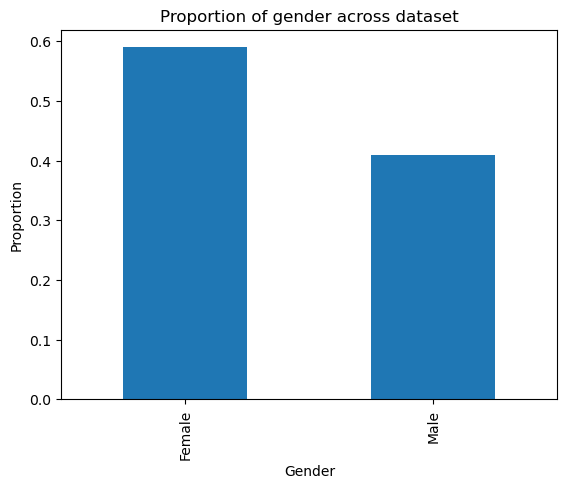

In [15]:
train.gender_of_respondent.value_counts(normalize=True).plot(kind = 'bar');
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.title('Proportion of gender across dataset');
plt.savefig('fig9.png')

Ratio of emale to male is 60%: 40%

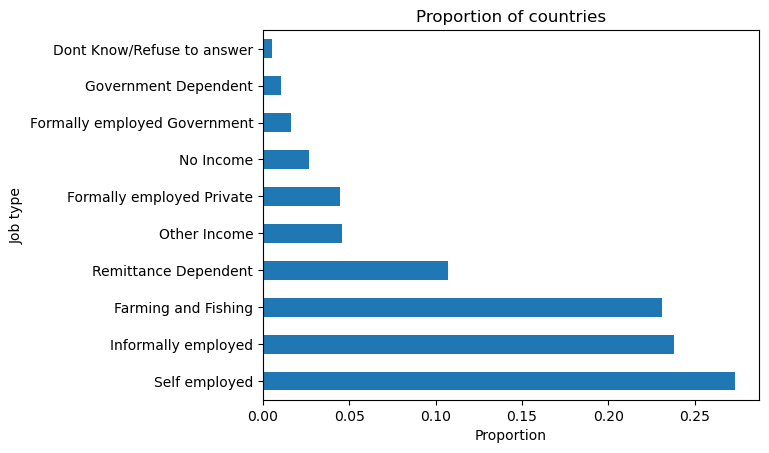

In [16]:
train.job_type.value_counts(normalize=True).plot(kind = 'barh');
plt.xlabel('Proportion')
plt.ylabel('Job type')
plt.title('Proportion of countries');
plt.savefig('fig10.png')

Self employed is the most popular job type. Government employed lead the rear.

In [17]:
# Print basic statistic for train dataframe
train.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


In [18]:
# Print the first 5 rows of test df
test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10086 entries, 0 to 10085
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 10086 non-null  object
 1   year                    10086 non-null  int64 
 2   uniqueid                10086 non-null  object
 3   location_type           10086 non-null  object
 4   cellphone_access        10086 non-null  object
 5   household_size          10086 non-null  int64 
 6   age_of_respondent       10086 non-null  int64 
 7   gender_of_respondent    10086 non-null  object
 8   relationship_with_head  10086 non-null  object
 9   marital_status          10086 non-null  object
 10  education_level         10086 non-null  object
 11  job_type                10086 non-null  object
dtypes: int64(3), object(9)
memory usage: 945.7+ KB


`test` dataframe consists of 10086 observations and 12 features. Fortunately, this dataframe has no NaNs and all the eatures seem to have the right datatypes

In [20]:
# Print variable_definitions dataframe
variable_definitions

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


In [21]:
# Print first 5 rows of sample_sambmission
sample_submission.head()

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0


## Data Preprocessing

In [22]:
# Drop target column
new_train = train.drop('bank_account', axis= 1)

In [23]:
def clean_dummy(df1, df2):
    

    """
    Concatenate, clean, and dummy dataframe .
    
    Parameters: 
           df1: X train dataframe
           df2: X test dataframe
    Returns: 
         X_train: cleaned and dummied X train matrix
         X_test: cleaned and dummied X test matrix
    """
    
    
    # Drop unwanted column
    df1 = df1.drop('uniqueid', axis = 1)
    df2 = df2.drop('uniqueid', axis = 1)
    
    # Concatenate the two dfs together row-wise
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    
    #dummy all the categorical columns
    for col in df.select_dtypes(
        include=[
            'object', 
            'bool'
        ]
    ).columns:
        df = pd.concat(
            [
                df.drop(col, axis=1), 
                pd.get_dummies(
                    df[col], 
                    prefix=col,
                    prefix_sep='_', 
                    drop_first=True, 
                    dummy_na=True)
            ], axis=1
        )
    # Split the data back after dummy
    X_train = df[:df1.shape[0]]
    X_test = df[df1.shape[0]:].reset_index(drop = True)
    return X_train, X_test

In [24]:
X_train, X_test = clean_dummy(new_train, test)

In [25]:
# Print first 5 rows of X_test
X_train.head()

,year,household_size,age_of_respondent,country_Rwanda,country_Tanzania,country_Uganda,country_nan,location_type_Urban,location_type_nan,cellphone_access_Yes,...,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed,job_type_nan
0,2018,3,24,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,2018,5,70,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2018,5,26,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3,2018,5,34,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,2018,8,26,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [26]:
# Check X_train shape
X_train.shape

(23524, 40)

In [27]:
# Print first 5 rows of X_test
X_test.head()

,year,household_size,age_of_respondent,country_Rwanda,country_Tanzania,country_Uganda,country_nan,location_type_Urban,location_type_nan,cellphone_access_Yes,...,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed,job_type_nan
0,2018,3,30,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
1,2018,7,51,0,0,0,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
2,2018,3,77,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2018,6,39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2018,3,16,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [28]:
# Check X_test shape
X_test.shape

(10086, 40)

In [29]:
def train_target(df):
    
    """
    Preprocess target variable.
    
    Parameters: 
           df: dataframe
    Returns: 
         y_train: preprocessed target
    """
    y_train = df.bank_account
    encoded = LabelEncoder()
    y_train = encoded.fit_transform(y_train)
    return y_train

In [30]:
y_train = train_target(train)

In [31]:
y_train.shape

(23524,)

In [32]:
def test_target(df1, df2):
    
    """
    Preprocess target variable.
    
    Parameters: 
           df1: sample submission dataframe
           df2: test dataframe
    Returns: 
         y_test: preprocessed target for model test
    """
    
    # Extract uniqueid from uniqueid column and form a separate column as uniqueid
    df1['uniqueid'] = df1.unique_id.str.split(' ', expand=True).get(0)
    
    # Merge df2 and df1 on index to have the same shape as df2
    merged_df = df2.merge(df1, left_index = True, right_index=True)
    # Extract target column from merged df
    y_test = merged_df.bank_account
    return y_test

In [33]:
y_test = test_target(sample_submission, test)

In [34]:
# y_test shape
y_test.shape

(10086,)

## Modeling and Result

In [35]:
# Build a randomforestclassifier 
rf = RandomForestClassifier()

# Fit the model
rf.fit(X_train, y_train)
# Score the model
rf.score(X_train, y_train)

0.9780649549396361

In [36]:
# Make prediction
y_pred = rf.predict(X_test)

In [37]:
# Check model's mean error
mean_absolute_error(y_test, y_pred)

0.09805671227443982

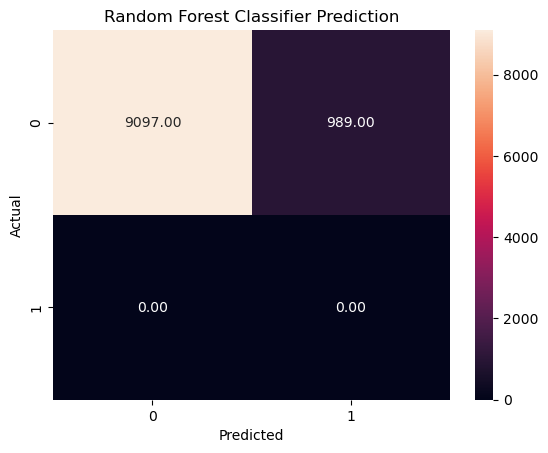

In [38]:
# Plot heat map of confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.2f');
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Classifier Prediction');

Out of 10086 records predicted, 9097 were correctly predicted as 0 (no account), and 989 were wrongly classified as 1 (yes account).

### Improving model

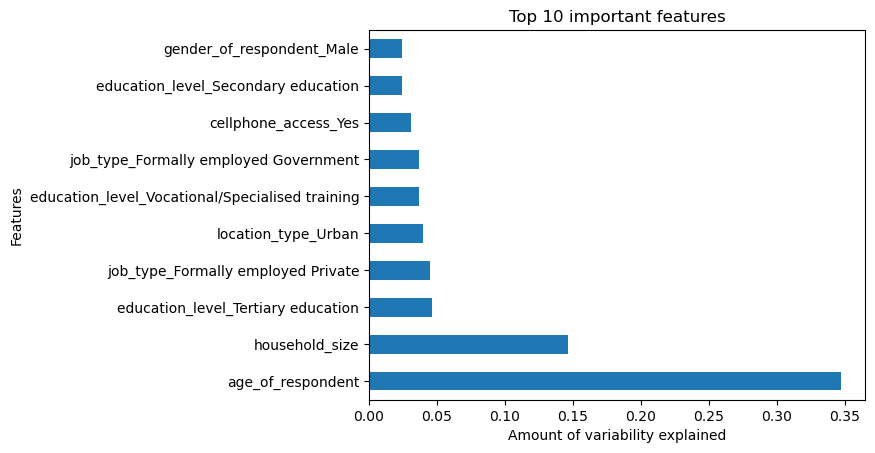

In [39]:
# Plot graph of top ten important featuresn
important_feat = pd.Series(rf.feature_importances_, index=X_train.columns)
important_feat.nlargest(10).plot(kind='barh');
plt.xlabel('Amount of variability explained')
plt.ylabel('Features')
plt.title('Top 10 important features');

`age of respondent` and `household size` dominate the top ten features.

In [40]:
# Extract most important feature
X_train_important = X_train[important_feat.nlargest(1).index]
X_test_important = X_test[important_feat.nlargest(1).index]

Mean absolute error: 0.0


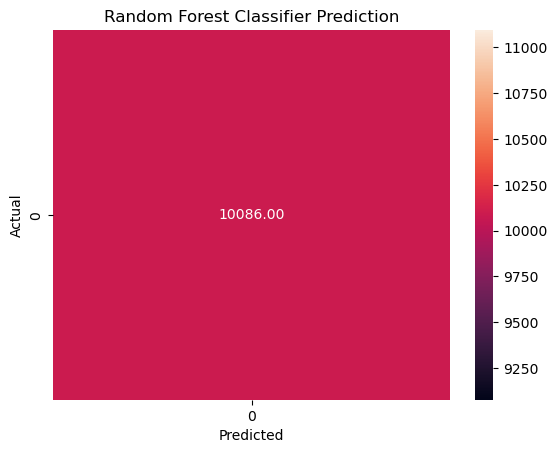

In [41]:
# Refit the model with most important feature
rf.fit(X_train_important, y_train)
# Score model
rf.score(X_train_important, y_train)
# Predict
y_pred_important = rf.predict(X_test_important)
# Check error
print('Mean absolute error:',mean_absolute_error(y_test, y_pred_important))

sns.heatmap(confusion_matrix(y_test, y_pred_important), annot=True, fmt='.2f');
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Classifier Prediction');

Out of 10086 records predicted, none was incorrectly classified. This indicates that feature selection is helpful in helping the model to correctly classify the test dataset.

In [42]:
# Inspect predicted values
y_pred_important

array([0, 0, 0, ..., 0, 0, 0])

In [43]:
# Form a dataframe with unique_id and predicted values columns
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": y_pred_important})

In [44]:
submission.head()

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,0
1,uniqueid_6060 x Kenya,0
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0


In [45]:
# save dataframe as cvs
submission.to_csv('submission.csv', index=False)

## Conclusion

The goal of this project was to build a machine learning model and use it to predict whether a person owns a bank account or not. Train data  was used to build the model and test data was used for prediction. After initial prediction, mean absolute error was 0.09. After feature extraction, the model was refitted, this time with important feature that has a very strong relationship with the target variable and prediction was made. This time, the model got all the predictions correctly.